In [ ]:

import pandas as pd

# Load the dataset from a CSV file
# df = pd.read_csv("/dbfs/FileStore/sequencing_result_april_22.csv")

df = spark.read.format('csv').options(inferSchema = True, header = True).load("/FileStore/credit_card_transactions.csv")
df = df.toPandas()
print(df)
# Show all the column names in the DataFrame to check for 'dob'
print(df.columns)

print(df['dob'].head())



         Unnamed: 0 trans_date_trans_time               cc_num  \
0                 0   2019-01-01 00:00:18     2703186189652095   
1                 1   2019-01-01 00:00:44         630423337322   
2                 2   2019-01-01 00:00:51       38859492057661   
3                 3   2019-01-01 00:01:16     3534093764340240   
4                 4   2019-01-01 00:03:06      375534208663984   
...             ...                   ...                  ...   
1296670     1296670   2020-06-21 12:12:08       30263540414123   
1296671     1296671   2020-06-21 12:12:19     6011149206456997   
1296672     1296672   2020-06-21 12:12:32     3514865930894695   
1296673     1296673   2020-06-21 12:13:36     2720012583106919   
1296674     1296674   2020-06-21 12:13:37  4292902571056973207   

                                    merchant       category     amt  \
0                 fraud_Rippin, Kub and Mann       misc_net    4.97   
1            fraud_Heller, Gutmann and Zieme    grocery_pos  107.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'zip', 'merch_zipcode'], inplace=True)

# Convert 'trans_date_trans_time' to datetime and extract useful time features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['transaction_day'] = df['trans_date_trans_time'].dt.day
df['transaction_month'] = df['trans_date_trans_time'].dt.month

# Ensure 'dob' column is in datetime format
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Calculate age
df['age'] = 2024 - df['dob'].dt.year

# Show the DataFrame with the new 'age' column
print(df[['dob', 'age']].head())

# Drop rows with missing values in merchant location data
df.dropna(subset=['merch_lat', 'merch_long'], inplace=True)

# Handle missing values for remaining columns
imputer = SimpleImputer(strategy='most_frequent')
df['gender'] = imputer.fit_transform(df[['gender']])

# Standardize numeric columns
scaler = StandardScaler()
df[['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']] = scaler.fit_transform(df[['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']])

# Feature set and target
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

print(df.columns)
print(df.head())

         dob  age
0 1988-03-09   36
1 1978-06-21   46
2 1962-01-19   62
3 1967-01-12   57
4 1986-03-28   38
Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour',
       'transaction_day', 'transaction_month', 'age'],
      dtype='object')
  trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category       amt gender            city state       lat      long  \
0       misc_net -0.40

/local_disk0/.ephemeral_nfs/envs/pythonEnv-93597a99-50b1-43f0-bd99-c9288a9886a2/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/databricks/python_shell/dbruntime/safe_oinspect.py:133: DeprecationWarning: `getargspec` function is deprecated as of IPython 7.10and will be removed in future versions.
  argspec = oinspect.getargspec(obj)


        support                                           itemsets
0      0.935910                                    (entertainment)
1      0.931841                                      (food_dining)
2      0.972533                                    (gas_transport)
3      0.933876                                      (grocery_net)
4      0.995931                                      (grocery_pos)
...         ...                                                ...
16378  0.923703  (gas_transport, health_fitness, grocery_pos, t...
16379  0.923703  (health_fitness, grocery_pos, travel, misc_pos...
16380  0.923703  (gas_transport, health_fitness, grocery_pos, m...
16381  0.923703  (gas_transport, health_fitness, grocery_pos, t...
16382  0.923703  (gas_transport, health_fitness, grocery_pos, t...

[16383 rows x 2 columns]


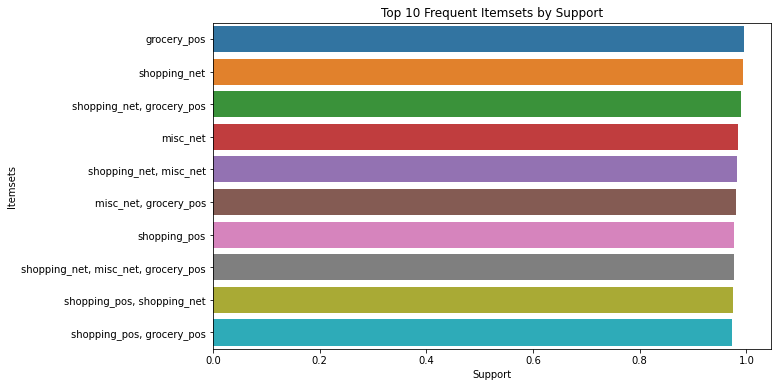

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Create a binary matrix for the 'category' column
basket = pd.get_dummies(df['category'])

# Group by 'cc_num' to represent transactions
basket = df.groupby(['cc_num'])['category'].apply(lambda x: ','.join(x)).str.get_dummies(',')

# Apply Apriori for frequent pattern mining
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Display results
print(frequent_itemsets)

# Visualization of frequent itemsets using a bar plot
# Plot only top 10 frequent itemsets by support
frequent_itemsets['itemsets_str'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets_str', data=frequent_itemsets.sort_values('support', ascending=False).head(10))
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()


In [ ]:
import networkx as nx

# Create a directed graph from association rules
plt.figure(figsize=(10,8))
G = nx.DiGraph()

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display rules
print(rules)

# Add nodes
for index, row in rules.iterrows():
    G.add_nodes_from(row['antecedents'], bipartite=0)
    G.add_nodes_from(row['consequents'], bipartite=1)

    # Add edges with confidence as weight
    G.add_edge(tuple(row['antecedents']), tuple(row['consequents']), weight=row['confidence'])

# Draw the network graph
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title("Association Rules Network Graph")
plt.show()


             antecedents                                        consequents  \
0          (food_dining)                                    (entertainment)   
1        (entertainment)                                      (food_dining)   
2        (gas_transport)                                    (entertainment)   
3        (entertainment)                                    (gas_transport)   
4          (grocery_net)                                    (entertainment)   
...                  ...                                                ...   
4750183       (misc_net)  (gas_transport, health_fitness, grocery_pos, t...   
4750184    (grocery_net)  (gas_transport, health_fitness, grocery_pos, t...   
4750185      (kids_pets)  (gas_transport, health_fitness, grocery_pos, t...   
4750186    (food_dining)  (gas_transport, health_fitness, grocery_pos, t...   
4750187   (shopping_net)  (gas_transport, health_fitness, grocery_pos, t...   

         antecedent support  consequent support   s

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-576024436066817>:22
     19     G.add_edge(tuple(row['antecedents']), tuple(row['consequents']), weight=row['confidence'])
     21 # Draw the network graph
---> 22 pos = nx.spring_layout(G, k=0.5, seed=42)
     23 nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='lightblue')
     24 nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-93597a99-50b1-43f0-bd99-c9288a9886a2/lib/python3.9/site-packages/networkx/utils/decorators.py:770, in argmap.__call__.<locals>.func(_argmap__wrapper, *args, **kwargs)
    769 def func(*args, __wrapper=None, **kwargs):
--> 770     return argmap._lazy_compile(__wrapper)(*args, **kwargs)

File <class 'networkx.utils.decorators.argmap'> compilation 4:4, in argmap_spring_layout_1(G, k, pos, fixed, iterations, threshold, weight, scale,

In [ ]:
pip install networkx

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
pip install mlxtend


Python interpreter will be restarted.
Python interpreter will be restarted.


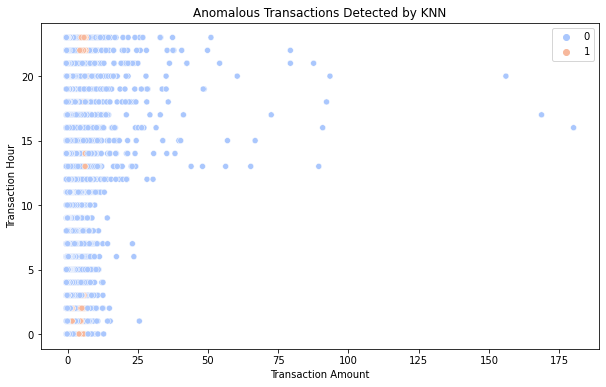

In [ ]:
# Split data for KNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Extract the transaction hour from the timestamp
df['transaction_hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour

# Define features (X) and target (y)
X = df[['amt', 'transaction_hour']]
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# KNN for anomaly detection
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict anomalies
y_pred = knn.predict(X_test)

# Plot KNN predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['amt'], y=X_test['transaction_hour'], hue=y_pred, palette='coolwarm')
plt.title('Anomalous Transactions Detected by KNN')
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Hour')
plt.show()




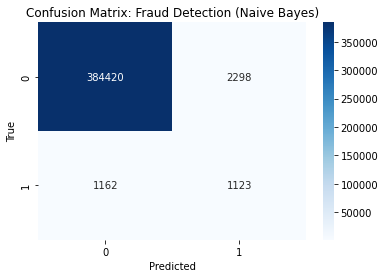

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    386718
           1       0.33      0.49      0.39      2285

    accuracy                           0.99    389003
   macro avg       0.66      0.74      0.69    389003
weighted avg       0.99      0.99      0.99    389003

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour',
       'transaction_day', 'transaction_month', 'age'],
      dtype='object')


In [ ]:
# Naive Bayes model for fraud detection
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict fraud
y_pred_nb = nb.predict(X_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Fraud Detection (Naive Bayes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_nb))
print(df.columns) 


/databricks/python_shell/dbruntime/safe_oinspect.py:133: DeprecationWarning: `getargspec` function is deprecated as of IPython 7.10and will be removed in future versions.
  argspec = oinspect.getargspec(obj)


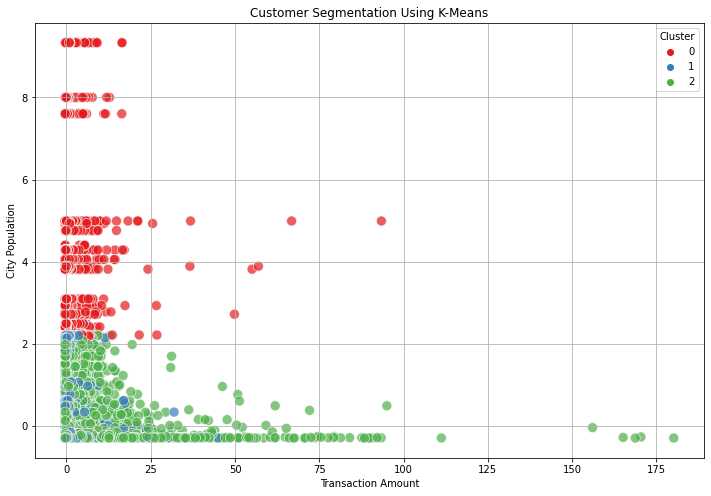

In [ ]:
from sklearn.cluster import KMeans

# Standardize features
features = ['amt', 'city_pop', 'lat', 'long', 'age']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df['amt'], y=df['city_pop'], hue=df['cluster'], palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segmentation Using K-Means')
plt.xlabel('Transaction Amount')
plt.ylabel('City Population')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
pip install hmmlearn

Python interpreter will be restarted.
Python interpreter will be restarted.


<command-576024436066824>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hmm_data['category'] = le.fit_transform(hmm_data['category'])
Model is not converging.  Current: -58002764.691006266 is not greater than -58002764.690995015. Delta is -1.125037670135498e-05


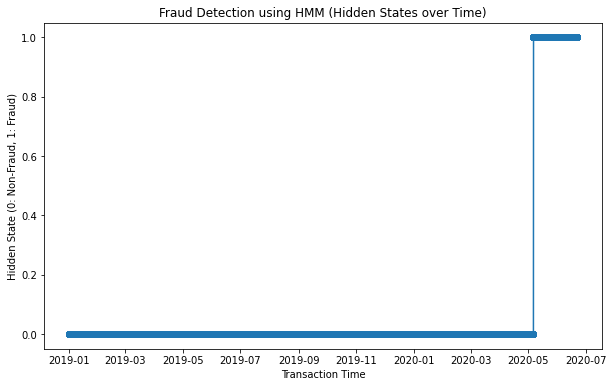

In [ ]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder

# Select relevant columns for time-series analysis (transaction amount, time, and merchant type)
hmm_data = df[['amt', 'cc_num','transaction_hour', 'category']]

# Encode the categorical features (merchant category)
le = LabelEncoder()
hmm_data['category'] = le.fit_transform(hmm_data['category'])

# Reshape the data to fit HMM: we assume one sequence of transactions for each card (grouped by cc_num)
hmm_data_grouped = hmm_data.groupby('cc_num').apply(lambda x: x.values).values
hmm_data_grouped = np.concatenate(hmm_data_grouped)  # Combine all grouped sequences for modeling

# Hidden Markov Model: We will assume 2 states for simplicity (fraud and non-fraud behavior)
model = hmm.GaussianHMM(n_components=2, covariance_type='diag', n_iter=100)

# Fit the HMM model
model.fit(hmm_data_grouped)

# Predict states for the transaction sequences
hidden_states = model.predict(hmm_data_grouped)

# Add hidden state to the dataframe for each transaction
df['hidden_state'] = hidden_states

# Visualize the hidden states (fraud vs non-fraud behavior over time)
plt.figure(figsize=(10, 6))
plt.plot(df['trans_date_trans_time'], df['hidden_state'], marker='o', linestyle='-')
plt.title('Fraud Detection using HMM (Hidden States over Time)')
plt.xlabel('Transaction Time')
plt.ylabel('Hidden State (0: Non-Fraud, 1: Fraud)')
plt.show()


<Figure size 864x576 with 0 Axes>

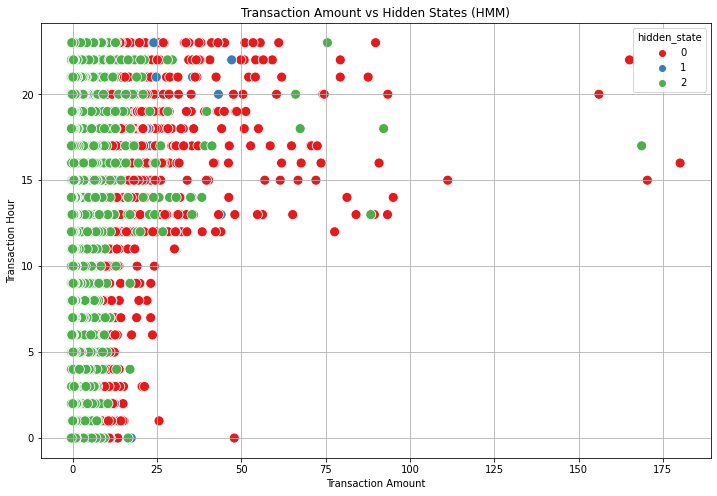

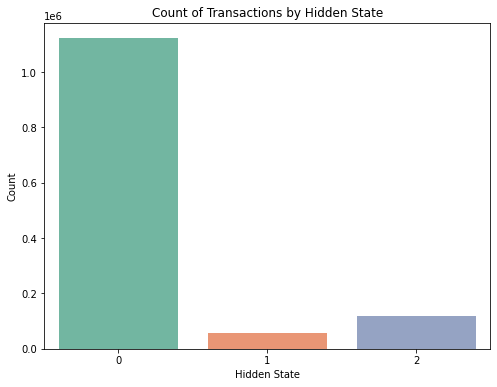

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder


# Encode the 'category' column into numerical values for HMM
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Prepare data for HMM (amt, transaction_hour, and encoded category)
hmm_data = df[['amt', 'cc_num', 'transaction_hour', 'category_encoded']]

# Group transactions by card number to simulate sequences
sequences = hmm_data.groupby('cc_num').apply(lambda x: x.values).tolist()

# Initialize the Hidden Markov Model with 3 components (3 hidden states)
model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=100)

# Fit the HMM model on all sequences concatenated
concatenated_data = np.concatenate(sequences)
model.fit(concatenated_data)

# Predict hidden states for each transaction sequence
hidden_states = model.predict(concatenated_data)

# Add hidden states back to the original DataFrame
df['hidden_state'] = np.concatenate([model.predict(seq) for seq in sequences])

# Visualize Hidden States: Transaction patterns by hidden states
plt.figure(figsize=(12, 8))

# Visualization 2: Transaction Amount vs Hidden States
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df['amt'], y=df['transaction_hour'], hue=df['hidden_state'], palette='Set1', s=100)
plt.title('Transaction Amount vs Hidden States (HMM)')
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Hour')
plt.grid(True)
plt.show()

# Visualization 3: Count of Transactions per Hidden State
plt.figure(figsize=(8, 6))
sns.countplot(x='hidden_state', data=df, palette='Set2')
plt.title('Count of Transactions by Hidden State')
plt.xlabel('Hidden State')
plt.ylabel('Count')
plt.show()


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


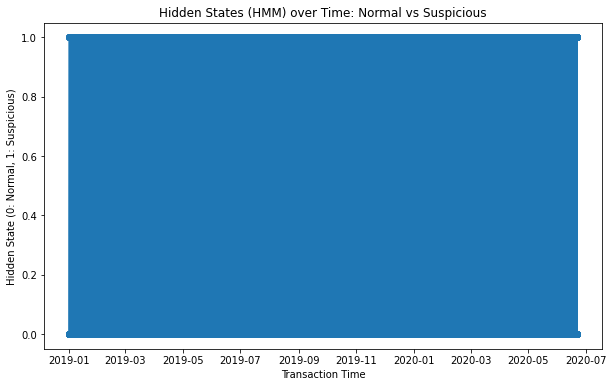

In [ ]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with relevant columns
# Select relevant columns for time-series analysis
hmm_data = df[['amt', 'cc_num', 'transaction_hour', 'category']].copy()

# Encode the categorical 'category' column using .loc to avoid setting a value on a slice
le = LabelEncoder()
hmm_data.loc[:, 'category_encoded'] = le.fit_transform(hmm_data['category'])

# Group data by 'cc_num' and ensure 'amt', 'transaction_hour', 'category_encoded' are correctly accessed
hmm_data_grouped = hmm_data.groupby('cc_num').apply(lambda x: x[['amt', 'transaction_hour', 'category_encoded']].values)

# Flatten the grouped data into a list of sequences for HMM
hmm_data_grouped = [sequence for sequence in hmm_data_grouped]

# Create Hidden Markov Model
model = hmm.GaussianHMM(n_components=2, covariance_type='diag', n_iter=100)

# Fit the HMM model to each sequence individually
# Ensure sequences are fit individually if necessary
for sequence in hmm_data_grouped:
    if len(sequence) > 1:  # HMM requires at least 2 samples per sequence
        model.fit(sequence)

# Predict hidden states for each sequence and concatenate the results
hidden_states = []
for sequence in hmm_data_grouped:
    if len(sequence) > 1:
        hidden_states.extend(model.predict(sequence))

# Add hidden states to the original DataFrame for analysis
df['hidden_state'] = np.nan
df.loc[df['cc_num'].isin(hmm_data['cc_num'].unique()), 'hidden_state'] = hidden_states

# Visualization of hidden states over transaction time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df['trans_date_trans_time'], df['hidden_state'], marker='o', linestyle='-')
plt.title('Hidden States (HMM) over Time: Normal vs Suspicious')
plt.xlabel('Transaction Time')
plt.ylabel('Hidden State (0: Normal, 1: Suspicious)')
plt.show()
